# Scalability of different methods in terms of input dimension
This Notebook runs experiment of dimensional scalability:

Stochastic Approximation is run on a number of neural nets with different dimensions,
Same algorithm is run for 1000, 5000, 10000, 50000 

In [1]:
import sys
import numpy as np

sys.path.append('..')

import torch 
import matplotlib.pyplot as plt

from relu_nets import ReLUNet  
from hyperbox import Hyperbox  
from other_methods import StochasticApproximation

In [93]:
# List of dims
dims = np.array([1, 50, 500, 3000, 7000, 10000])
dims

array([    1,    50,   500,  3000,  7000, 10000])

In [94]:
def get_random_dataset(num_points, radius, num_lakes, dim):
    X = np.random.uniform(-radius, radius, size=(num_points, dim))
    X = torch.Tensor(X)

    def generate_random_lakes(num_lakes, r, dim):
        lks = []
        for _ in range(num_lakes):
            coords = tuple(np.random.uniform(-r, r, size=dim))
            size = np.random.uniform(0.1 * r, 0.4 * r)
            lks.append((coords, size))
        return lks

    lakes = generate_random_lakes(num_lakes=num_lakes, r=radius, dim=dim)

    def is_in_region(point):
        return any(np.linalg.norm(point - np.array(center)) < radius for center, radius in lakes)

    y = np.array([-1.0 if is_in_region(p) else 1.0 for p in X])
    y += np.random.normal(scale=0.2, size=y.shape)
    y = torch.Tensor(y)

    return X, y

def get_trained_network(layer_sizes, rad, dim):
    test_network = ReLUNet(layer_sizes)
    num_points = 300
    X, y = get_random_dataset(num_points=num_points, radius=rad, num_lakes=np.random.randint(1, 5), dim=dim)
    train_X = X
    train_y = y.unsqueeze(1)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(test_network.parameters(), lr=2e-4)

    epochs = 300
    for epoch in range(epochs):
        test_network.train()
        pred = test_network(train_X)
        loss = loss_fn(pred, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return test_network

In [95]:
# List of networks to test methods on, all Networks have 2 hidden layers of width 16
networks = []
domains = []
width = 16

for i in range(len(dims)):
    layer_sizes = [dims[i]] + [width] * 2 + [1]
    test_network = get_trained_network(layer_sizes, rad=0.5, dim=dims[i])
    domains.append(Hyperbox.build_unit_hypercube(dims[i]))
    networks.append(test_network)

In [96]:
result = {1000: np.zeros((len(dims), 5)),
          10000: np.zeros((len(dims), 5)),
          40000: np.zeros((len(dims), 5)),
          100000: np.zeros((len(dims), 5))}
time = {1000: np.zeros((len(dims), 5)),
        10000: np.zeros((len(dims), 5)),
        40000: np.zeros((len(dims), 5)),
        100000: np.zeros((len(dims), 5))}

for i in range(len(dims)):
    for j in range(5):
        network = networks[i]
        domain = domains[i]
        SA_1000 = StochasticApproximation(network, c_vector=torch.tensor([1.0]), domain=domain, use_c_vector=True)
        result[1000][i][j] = SA_1000.compute(max_iter=1000, v=False)
        time[1000][i][j] = SA_1000.compute_time
        
        SA_10000 = StochasticApproximation(network, c_vector=torch.tensor([1.0]), domain=domain, use_c_vector=True)
        result[10000][i][j] = SA_10000.compute(max_iter=10000, v=False)
        time[10000][i][j] = SA_10000.compute_time
        
        SA_40000 = StochasticApproximation(network, c_vector=torch.tensor([1.0]), domain=domain, use_c_vector=True)
        result[40000][i][j] = SA_40000.compute(max_iter=40000, v=False)
        time[40000][i][j] = SA_40000.compute_time

        SA_100000 = StochasticApproximation(network, c_vector=torch.tensor([1.0]), domain=domain, use_c_vector=True)
        result[100000][i][j] = SA_100000.compute(max_iter=100000, v=False)
        time[100000][i][j] = SA_100000.compute_time
    

Text(0.5, 0.98, 'Stochastic Approximation performance for different input dimension')

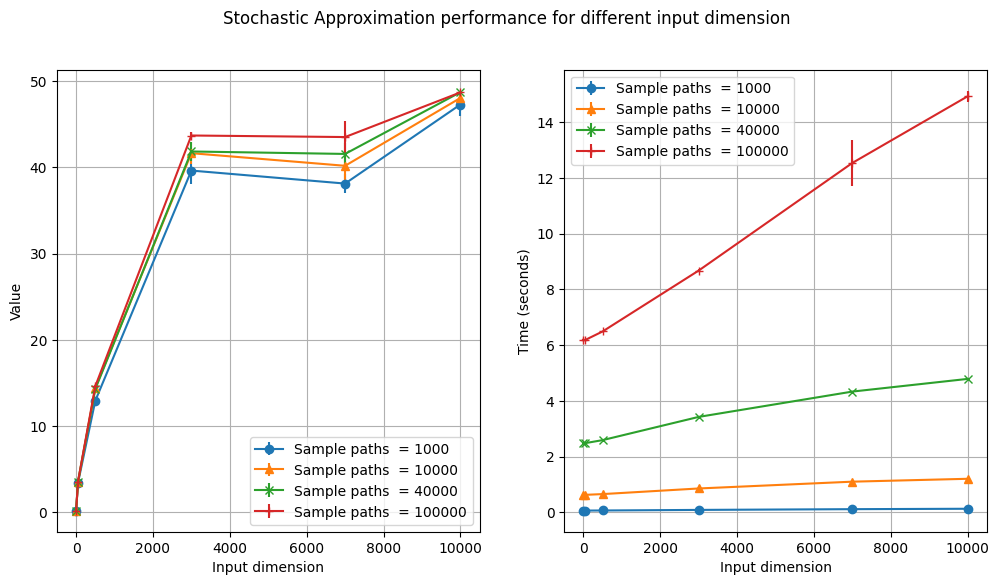

In [98]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for key in result.keys():
    mr = 'o'
    if key == 10000: 
        mr = '^'
    if key == 40000: 
        mr = 'x'
    if key == 100000: 
        mr = '+'
    ax1.errorbar(dims, result[key].mean(axis=1), yerr=result[key].std(axis=1), label=f"Sample paths  = {key}", marker=mr)
    ax2.errorbar(dims, time[key].mean(axis=1), yerr=time[key].std(axis=1), label=f"Sample paths  = {key}", marker=mr)
ax1.grid(True)
ax1.set_xlabel('Input dimension')
ax1.set_ylabel('Value')
# ax1.set_yscale('log')
ax1.legend()
ax2.grid(True)
ax2.set_xlabel('Input dimension')
ax2.set_ylabel('Time (seconds)')
ax2.legend()
plt.suptitle('Stochastic Approximation performance for different input dimension')